In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
from geopandas.tools import sjoin

In [3]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [6]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
(0.8443906332745678, 0.4051139537590416)


In [7]:
shp.crs

{}

In [8]:
gpd.read_file('../Data/Geo_Data/geo/london_wards.shp')

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
0,Chessington South Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,52,733,50840,10884,E05000405,755.173,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Tolworth and Hook Rise Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,106,734,117160,11407,E05000414,259.464,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606..."
2,Berrylands Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,107,735,50449,11413,E05000401,145.390,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252..."
3,Alexandra Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,108,736,50456,11420,E05000400,268.506,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838..."
4,Beverley Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,109,737,117161,11417,E05000402,187.821,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921..."
5,Coombe Hill Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,118,738,117159,11423,E05000406,442.170,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.24714 51.40958, -0.24820 51.41018..."
6,Chessington North and Hook Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,308,739,50530,11406,E05000404,192.980,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.31830 51.36368, -0.31841 51.36468..."
7,Surbiton Hill Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,309,740,50457,11421,E05000413,166.482,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.31316 51.38880, -0.30599 51.39168..."
8,Old Malden Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,310,741,50455,11419,E05000410,180.016,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.24505 51.38004, -0.24553 51.38006..."
9,St. Mark's Ward,LBW,London Borough Ward,GREATER_LONDON_AUTHORITY,313,742,50450,11414,E05000412,137.578,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.31298 51.39711, -0.31256 51.39688..."


(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7fe38aeda850>)

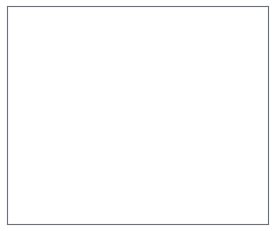

In [10]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    '../Data/Geo_Data/geo/london_wards',
    'london',
    color='none',
    zorder=2)

In [11]:
m(58.6, -0)

(8381524.148270389, -5684368.573050952)

In [12]:
london_polys = []
borough_names = []
for w_ind in range(len(m.london_info)):
    w = m.london_info[w_ind]
    if w['NAME'] in borough_names:
        london_polys[-1] = Polygon(m.london[w_ind])
        continue
    borough_names.append(w['NAME'])    
    london_polys.append(Polygon(m.london[w_ind]))
    
df_map = pd.DataFrame({
    'poly': london_polys,
    'borough_name': borough_names,
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['borough_name'] = df_map['borough_name'].str.strip()

In [14]:
data_file1 = '../Data/Geo_Data/GreaterLondon_NoRot_segnet.csv'
lonlat_data_file = '../Data/Geo_Data/greater_london_points.csv'

In [15]:
SegnetLabels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [16]:
gsview_lonlat = {}
fdata = {}
fdata_map_points = {}
gsview_data = {}
all_tags = {}
count = 0
threshold = 0.95

with open(lonlat_data_file, 'r') as infile:
    for line in infile:
        fields = line.strip().split(',')
        gsview_lonlat['_'.join([fields[0], fields[1], '0'])] = (float(fields[2]),float(fields[3]))               
        
count = 0
with open(data_file1, 'r') as infile:
    for line in infile:
        count += 1
        
        if count == 1:
            continue
        fields = line.strip().split('|')
        # ignore the rotation tag 0,1,2,4 for angle of rotation
        if len(fields) < 2:
            continue
        
        way_id   = fields[0]
        point_id = fields[1]
        rotation = fields[2]
        fields[3] = fields[3][1:-1]
        scene_list = list(map(float, fields[3].split(', ')))
        latitude  = gsview_lonlat['_'.join(fields[:3])][0]
        longitude = gsview_lonlat['_'.join(fields[:3])][1]
        fdata_map_points[m(longitude, latitude)] = scene_list

In [17]:
print Point(fdata_map_points.keys()[1])

POINT (43165.67951267029 19464.87639720811)


In [18]:
map_points = pd.Series(
    [Point(map_point) for map_point in fdata_map_points])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = list(filter(wards_polygon.contains, plaque_points))

In [19]:
len(df_map)

627

In [20]:
map_points = pd.Series(
    [Point(mapped_x, mapped_y) for (mapped_x, mapped_y) in fdata_map_points])
gsview_points = MultiPoint(list(map_points.values))
# calculate points that fall within the London boundary
gsview_ldn_points = list(filter(wards_polygon.contains, gsview_points))
# create a MultiPoint which we can check for set membership
df_map['gsview_point_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, gsview_ldn_points)))
df_map['gsview_segnet_tags_dict'] = df_map['gsview_point_list'].map(lambda x: [fdata_map_points[(p.x,p.y)] for p in x])

In [21]:
df_map

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict
0,Chessington South Ward,"POLYGON ((13004.06946679378 5643.556704930117,...",7.557384e+06,75.573841,"[POINT (14125.90147603366 8949.628961333685), ...","[[0.248032407407, 0.248420138889, 0.0088773148..."
1,Tolworth and Hook Rise Ward,"POLYGON ((14432.57909461121 10890.80719812433,...",2.596590e+06,25.965904,"[POINT (15785.12071092852 10683.26380937701), ...","[[0.321105324074, 0.175827546296, 0.0061111111..."
2,Berrylands Ward,"POLYGON ((14710.57509348575 12747.79659884245,...",1.454965e+06,14.549655,"[POINT (14943.12438919347 12861.81755012056), ...","[[0.146163194444, 0.0374537037037, 0.008495370..."
3,Alexandra Ward,"POLYGON ((17083.95639115885 12354.05967180899,...",2.687010e+06,26.870103,"[POINT (16861.33974843501 10669.48940821065), ...","[[0.226550925926, 0.00512731481481, 7.52314814..."
4,Beverley Ward,"POLYGON ((18675.54168399898 13589.62372055175,...",1.879597e+06,18.795975,"[POINT (17160.45934672326 13436.4304767139), P...","[[0.129583333333, 0.374895833333, 0.0017939814..."
5,Coombe Hill Ward,"POLYGON ((18612.11378584463 14742.45080214852,...",4.424962e+06,44.249620,"[POINT (17891.20284518503 17546.77887998099), ...","[[0.374577546296, 0.0157349537037, 0.011232638..."
6,Chessington North and Hook Ward,"POLYGON ((13778.04166202739 9520.496764869342,...",1.931236e+06,19.312361,"[POINT (14386.05607928922 9663.164811627386), ...","[[0.372355324074, 0.14150462963, 0.01096064814..."
7,Surbiton Hill Ward,"POLYGON ((14072.14004289791 12322.73661365363,...",1.666071e+06,16.660709,"[POINT (14935.41453690581 11876.22478102226), ...","[[0.240306712963, 0.153998842593, 0.0193865740..."
8,Old Malden Ward,"POLYGON ((18835.70916394518 11458.93453373256,...",1.801488e+06,18.014876,"[POINT (18220.31392281597 12385.60326166448), ...","[[0.396591435185, 0.0436631944444, 0.009907407..."
9,St. Mark's Ward,"POLYGON ((14063.43330370706 13247.47936071208,...",1.376784e+06,13.767837,"[POINT (14690.63313046888 13220.93733637573), ...","[[0.251469907407, 0.163159722222, 0.0056655092..."


In [22]:
np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[0]), axis=0)
scene_tags = []
total_pixels = []
for index in range(len(df_map)):
    scene_tags.append(np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
    total_pixels.append(np.sum(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
df_map['gsview_tags'] = scene_tags
df_map['total_gsview_pixels'] = total_pixels

cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']

scene_tags_transpose = list(zip(*scene_tags))
scene_total_transpose = list(zip(*total_pixels))

for index in range(len(cats)):
    cat = cats[index]
    cat_total =  cats[index] + 'Total'
    df_map[cat] = scene_tags_transpose[index]
    df_map[cat_total] = scene_total_transpose[index]
    

In [23]:
np.array(df_map['gsview_segnet_tags_dict'].iloc[index])

array([[1.42129630e-01, 3.78298611e-02, 8.75000000e-03, 4.95949074e-03,
        2.81666667e-01, 8.08680556e-02, 3.87991898e-01, 2.60416667e-04,
        2.47569444e-02, 2.90567130e-02, 1.40046296e-03, 3.29861111e-04],
       [2.85665509e-01, 2.24097222e-01, 1.63657407e-02, 9.62384259e-03,
        1.73582176e-01, 1.43275463e-01, 5.29108796e-02, 9.66435185e-03,
        1.35127315e-02, 7.06018519e-02, 4.68750000e-04, 2.31481481e-04],
       [9.73466435e-01, 3.68055556e-03, 1.01273148e-03, 9.83796296e-05,
        8.36226852e-03, 5.73495370e-03, 7.69675926e-04, 1.11111111e-03,
        1.29050926e-03, 3.72106481e-03, 0.00000000e+00, 7.52314815e-04],
       [0.00000000e+00, 6.83524306e-01, 8.11921296e-03, 8.10185185e-05,
        5.93171296e-03, 2.98136574e-01, 4.16666667e-04, 1.66087963e-03,
        8.50694444e-04, 7.11805556e-04, 3.58796296e-04, 2.08333333e-04],
       [3.35052083e-01, 1.87349537e-01, 7.84722222e-03, 0.00000000e+00,
        3.08738426e-02, 1.27320602e-01, 8.80266204e-02, 1.08

In [24]:
len(zip(*scene_tags)[0])

627

In [25]:
df_map

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Sign_Symbol,Sign_SymbolTotal,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal
0,Chessington South Ward,"POLYGON ((13004.06946679378 5643.556704930117,...",7.557384e+06,75.573841,"[POINT (14125.90147603366 8949.628961333685), ...","[[0.248032407407, 0.248420138889, 0.0088773148...","[0.3045318680330815, 0.13717390327220425, 0.00...","[31.3667824074074, 14.128912037037038, 0.80149...",0.304532,31.366782,...,0.000928,0.095561,0.024018,2.473877,0.041978,4.323721,0.002050,0.211134,0.000971,0.100023
1,Tolworth and Hook Rise Ward,"POLYGON ((14432.57909461121 10890.80719812433,...",2.596590e+06,25.965904,"[POINT (15785.12071092852 10683.26380937701), ...","[[0.321105324074, 0.175827546296, 0.0061111111...","[0.29897431657848317, 0.17237064594356266, 0.0...","[31.392303240740734, 18.09891782407408, 1.1074...",0.298974,31.392303,...,0.001452,0.152425,0.031277,3.284120,0.043015,4.516557,0.002106,0.221123,0.000980,0.102911
2,Berrylands Ward,"POLYGON ((14710.57509348575 12747.79659884245,...",1.454965e+06,14.549655,"[POINT (14943.12438919347 12861.81755012056), ...","[[0.146163194444, 0.0374537037037, 0.008495370...","[0.2685991379310345, 0.17140674888250318, 0.00...","[15.578750000000003, 9.941591435185185, 0.4341...",0.268599,15.578750,...,0.000871,0.050521,0.025375,1.471771,0.061419,3.562303,0.004219,0.244693,0.001649,0.095625
3,Alexandra Ward,"POLYGON ((17083.95639115885 12354.05967180899,...",2.687010e+06,26.870103,"[POINT (16861.33974843501 10669.48940821065), ...","[[0.226550925926, 0.00512731481481, 7.52314814...","[0.3125163152610444, 0.12744589468987064, 0.01...","[25.938854166666683, 10.578009259259263, 1.035...",0.312516,25.938854,...,0.001190,0.098744,0.032238,2.675752,0.050902,4.224902,0.002187,0.181551,0.001038,0.086128
4,Beverley Ward,"POLYGON ((18675.54168399898 13589.62372055175,...",1.879597e+06,18.795975,"[POINT (17160.45934672326 13436.4304767139), P...","[[0.129583333333, 0.374895833333, 0.0017939814...","[0.27354906528363815, 0.2019754307313643, 0.00...","[21.610376157407412, 15.956059027777782, 0.640...",0.273549,21.610376,...,0.001375,0.108594,0.027509,2.173229,0.066564,5.258571,0.002800,0.221233,0.000981,0.077488
5,Coombe Hill Ward,"POLYGON ((18612.11378584463 14742.45080214852,...",4.424962e+06,44.249620,"[POINT (17891.20284518503 17546.77887998099), ...","[[0.374577546296, 0.0157349537037, 0.011232638...","[0.4812529906164558, 0.061979904610986826, 0.0...","[71.70669560185192, 9.235005787037037, 0.91114...",0.481253,71.706696,...,0.001824,0.271834,0.024758,3.688889,0.024296,3.620104,0.001185,0.176574,0.000657,0.097963
6,Chessington North and Hook Ward,"POLYGON ((13778.04166202739 9520.496764869342,...",1.931236e+06,19.312361,"[POINT (14386.05607928922 9663.164811627386), ...","[[0.372355324074, 0.14150462963, 0.01096064814...","[0.30126322751322754, 0.1703617273929774, 0.00...","[23.19726851851852, 13.117853009259258, 0.6581...",0.301263,23.197269,...,0.001123,0.086505,0.028200,2.171435,0.046218,3.558791,0.002092,0.161094,0.001269,0.097743
7,Surbiton Hill Ward,"POLYGON ((14072.14004289791 12322.73661365363,...",1.666071e+06,16.660709,"[POINT (14935.41453690581 11876.22478102226), ...","[[0.240306712963, 0.153998842593, 0.0193865740...","[0.2319244057490327, 0.12274461028192374, 0.00...","[15.53893518518519, 8.22388888888889, 0.525914...",0.231924,15.538935,...,0.001357,0.090926,0.028525,1.911152,0.039862,2.670729,0.001569,0.105104,0.000418,0.028003
8,Old Malden Ward,"POLYGON ((18835.70916394518 11458.93453373256,...",1.801488e+06,18.014876,"[POINT (18220.31392281597 12385.60326166448), ...","[[0.396591435185, 0.0436631944444, 0.009907407...","[0.29623624639249635, 0.13735201719576715, 0.0...","[22.81019097222222, 10.57610532407407, 0.66979...",0.296236,22.810191,...,0.001236,0.095191,0.029096,2.240399,0.040733,3.136406,0.002006,0.154497,0.001037,0.079878
9,St

In [26]:
df_map.columns

Index([u'borough_name', u'poly', u'area_m', u'area_km', u'gsview_point_list',
       u'gsview_segnet_tags_dict', u'gsview_tags', u'total_gsview_pixels',
       u'Sky', u'SkyTotal', u'Building', u'BuildingTotal', u'Pole',
       u'PoleTotal', u'Road_Marking', u'Road_MarkingTotal', u'Road',
       u'RoadTotal', u'Pavement', u'PavementTotal', u'Tree', u'TreeTotal',
       u'Sign_Symbol', u'Sign_SymbolTotal', u'Fence', u'FenceTotal',
       u'Vehicle', u'VehicleTotal', u'Pedestrian', u'PedestrianTotal', u'Bike',
       u'BikeTotal'],
      dtype='object')

In [28]:
tree_data = pd.read_csv('../Data/Geo_Data/london_street_trees_gla_20180214.csv')

In [29]:
len(tree_data)

726934

In [30]:
treeLocations = []
for index , row in tree_data.iterrows():
    point = Point(m(row['longitude'], row['latitude']))
    treeLocations.append(point)

In [31]:
print treeLocations[1]

POINT (44911.20345936637 35044.0926956278)


In [33]:
tree_points = pd.Series(treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['TreeCount'] = df_map['Tree_location_list'].map(lambda x: len(x))

In [34]:
df_map.head()

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal,Tree_location_list,TreeCount
0,Chessington South Ward,"POLYGON ((13004.06946679378 5643.556704930117,...",7.557384e+06,75.573841,"[POINT (14125.90147603366 8949.628961333685), ...","[[0.248032407407, 0.248420138889, 0.0088773148...","[0.3045318680330815, 0.13717390327220425, 0.00...","[31.3667824074074, 14.128912037037038, 0.80149...",0.304532,31.366782,...,0.024018,2.473877,0.041978,4.323721,0.002050,0.211134,0.000971,0.100023,"[POINT (14517.9631249908 9426.159779180685), P...",91
1,Tolworth and Hook Rise Ward,"POLYGON ((14432.57909461121 10890.80719812433,...",2.596590e+06,25.965904,"[POINT (15785.12071092852 10683.26380937701), ...","[[0.321105324074, 0.175827546296, 0.0061111111...","[0.29897431657848317, 0.17237064594356266, 0.0...","[31.392303240740734, 18.09891782407408, 1.1074...",0.298974,31.392303,...,0.031277,3.284120,0.043015,4.516557,0.002106,0.221123,0.000980,0.102911,"[POINT (16576.51872432181 10953.0350912103), P...",53
2,Berrylands Ward,"POLYGON ((14710.57509348575 12747.79659884245,...",1.454965e+06,14.549655,"[POINT (14943.12438919347 12861.81755012056), ...","[[0.146163194444, 0.0374537037037, 0.008495370...","[0.2685991379310345, 0.17140674888250318, 0.00...","[15.578750000000003, 9.941591435185185, 0.4341...",0.268599,15.578750,...,0.025375,1.471771,0.061419,3.562303,0.004219,0.244693,0.001649,0.095625,[],0
3,Alexandra Ward,"POLYGON ((17083.95639115885 12354.05967180899,...",2.687010e+06,26.870103,"[POINT (16861.33974843501 10669.48940821065), ...","[[0.226550925926, 0.00512731481481, 7.52314814...","[0.3125163152610444, 0.12744589468987064, 0.01...","[25.938854166666683, 10.578009259259263, 1.035...",0.312516,25.938854,...,0.032238,2.675752,0.050902,4.224902,0.002187,0.181551,0.001038,0.086128,"[POINT (16524.99709356503 11497.43654827776), ...",74
4,Beverley Ward,"POLYGON ((18675.54168399898 13589.62372055175,...",1.879597e+06,18.795975,"[POINT (17160.45934672326 13436.4304767139), P...","[[0.129583333333, 0.374895833333, 0.0017939814...","[0.27354906528363815, 0.2019754307313643, 0.00...","[21.610376157407412, 15.956059027777782, 0.640...",0.273549,21.610376,...,0.027509,2.173229,0.066564,5.258571,0.002800,0.221233,0.000981,0.077488,[],0


In [35]:
gdf = gpd.GeoDataFrame(df_map, crs={}, geometry='poly')

In [37]:
gdf

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal,Tree_location_list,TreeCount
0,Chessington South Ward,"POLYGON ((13004.069 5643.557, 13009.772 5652.2...",7.557384e+06,75.573841,"[POINT (14125.90147603366 8949.628961333685), ...","[[0.248032407407, 0.248420138889, 0.0088773148...","[0.3045318680330815, 0.13717390327220425, 0.00...","[31.3667824074074, 14.128912037037038, 0.80149...",0.304532,31.366782,...,0.024018,2.473877,0.041978,4.323721,0.002050,0.211134,0.000971,0.100023,"[POINT (14517.9631249908 9426.159779180685), P...",91
1,Tolworth and Hook Rise Ward,"POLYGON ((14432.579 10890.807, 14440.082 10913...",2.596590e+06,25.965904,"[POINT (15785.12071092852 10683.26380937701), ...","[[0.321105324074, 0.175827546296, 0.0061111111...","[0.29897431657848317, 0.17237064594356266, 0.0...","[31.392303240740734, 18.09891782407408, 1.1074...",0.298974,31.392303,...,0.031277,3.284120,0.043015,4.516557,0.002106,0.221123,0.000980,0.102911,"[POINT (16576.51872432181 10953.0350912103), P...",53
2,Berrylands Ward,"POLYGON ((14710.575 12747.797, 14717.378 12751...",1.454965e+06,14.549655,"[POINT (14943.12438919347 12861.81755012056), ...","[[0.146163194444, 0.0374537037037, 0.008495370...","[0.2685991379310345, 0.17140674888250318, 0.00...","[15.578750000000003, 9.941591435185185, 0.4341...",0.268599,15.578750,...,0.025375,1.471771,0.061419,3.562303,0.004219,0.244693,0.001649,0.095625,[],0
3,Alexandra Ward,"POLYGON ((17083.956 12354.060, 17094.660 12346...",2.687010e+06,26.870103,"[POINT (16861.33974843501 10669.48940821065), ...","[[0.226550925926, 0.00512731481481, 7.52314814...","[0.3125163152610444, 0.12744589468987064, 0.01...","[25.938854166666683, 10.578009259259263, 1.035...",0.312516,25.938854,...,0.032238,2.675752,0.050902,4.224902,0.002187,0.181551,0.001038,0.086128,"[POINT (16524.99709356503 11497.43654827776), ...",74
4,Beverley Ward,"POLYGON ((18675.542 13589.624, 18668.439 13588...",1.879597e+06,18.795975,"[POINT (17160.45934672326 13436.4304767139), P...","[[0.129583333333, 0.374895833333, 0.0017939814...","[0.27354906528363815, 0.2019754307313643, 0.00...","[21.610376157407412, 15.956059027777782, 0.640...",0.273549,21.610376,...,0.027509,2.173229,0.066564,5.258571,0.002800,0.221233,0.000981,0.077488,[],0
5,Coombe Hill Ward,"POLYGON ((18612.114 14742.451, 18536.285 14807...",4.424962e+06,44.249620,"[POINT (17891.20284518503 17546.77887998099), ...","[[0.374577546296, 0.0157349537037, 0.011232638...","[0.4812529906164558, 0.061979904610986826, 0.0...","[71.70669560185192, 9.235005787037037, 0.91114...",0.481253,71.706696,...,0.024758,3.688889,0.024296,3.620104,0.001185,0.176574,0.000657,0.097963,"[POINT (18401.57420806239 15390.48764707943), ...",64
6,Chessington North and Hook Ward,"POLYGON ((13778.042 9520.497, 13768.138 9631.5...",1.931236e+06,19.312361,"[POINT (14386.05607928922 9663.164811627386), ...","[[0.372355324074, 0.14150462963, 0.01096064814...","[0.30126322751322754, 0.1703617273929774, 0.00...","[23.19726851851852, 13.117853009259258, 0.6581...",0.301263,23.197269,...,0.028200,2.171435,0.046218,3.558791,0.002092,0.161094,0.001269,0.097743,"[POINT (14505.65813167962 9519.194190858543), ...",39
7,Surbiton Hill Ward,"POLYGON ((14072.140 12322.737, 14563.521 12654...",1.666071e+06,16.660709,"[POINT (14935.41453690581 11876.22478102226), ...","[[0.240306712963, 0.153998842593, 0.0193865740...","[0.2319244057490327, 0.12274461028192374, 0.00...","[15.53893518518519, 8.22388888888889, 0.525914...",0.231924,15.538935,...,0.028525,1.911152,0.039862,2.670729,0.001569,0.105104,0.000418,0.028003,[],0
8,Old Malden Ward,"POLYGON ((18835.709 11458.935, 18802.597 11460...",1.801488e+06,18.014876,"[POINT (18220.31392281597 12385.60326166448), ...","[[0.396591435185, 0.0436631944444, 0.009907407...","[0.29623624639249635, 0.13735201719576715, 0.0...","[22.81019097222222, 10

In [38]:
# gdf.to_csv('Tree_Segnet.csv')

In [88]:
# df_map = pd.read_csv('Tree_Segnet.csv')

In [39]:
gdf['total_gsview_pixels'].iloc[2]

array([15.57875   ,  9.94159144,  0.4341956 ,  0.37415509,  9.69751157,
        4.88596644, 11.66291667,  0.05052083,  1.47177083,  3.56230324,
        0.24469329,  0.095625  ])

In [40]:
sum(gdf['TreeCount'])

708330

In [41]:
polygon = gdf.iloc[15]['poly']

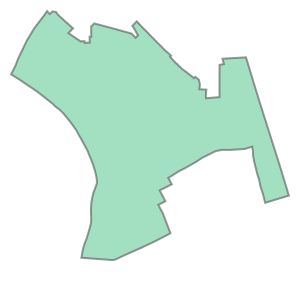

In [42]:
polygon

In [43]:
gdf.iloc[15].area_km

15.836944503529978

In [44]:
polygon.area

1583694.4503529978

In [45]:
gdf[gdf['TreeCount'] > 17000]

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Fence,FenceTotal,Vehicle,VehicleTotal,Pedestrian,PedestrianTotal,Bike,BikeTotal,Tree_location_list,TreeCount
302,Chase Ward,"POLYGON ((24334.019 45146.742, 24333.919 45145...",1.694799e+07,169.479942,"[POINT (26274.98947541893 44610.31791361063), ...","[[0.137199074074, 0.00078125, 0.00163773148148...","[0.2713971616331097, 0.11238911415610245, 0.00...","[40.43817708333334, 16.745978009259264, 1.0485...",0.271397,40.438177,...,0.028172,4.197679,0.043575,6.492633,0.00179,0.266782,0.000764,0.1139,"[POINT (25763.26980466336 43641.18778887563), ...",18584


In [106]:
# df_map.to_csv('Tree_Segnet.csv')

In [46]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = gdf['TreeCount'].values.astype(float)
x2 = gdf['Tree'].values.astype(float)

minVal = float(np.min(x))
maxVal = float(np.max(x))

min_tree = float(np.min(x2))
max_tree = float(np.max(x2))

gdf['NormedTreeCount'] = (gdf['TreeCount']-minVal)/(maxVal-minVal)
gdf['NormedTreeSegnet'] = (gdf['Tree']-min_tree)/(max_tree-min_tree)

gdf['TreeDensity'] = (gdf['TreeCount']*10.0)/gdf['area_km']
gdf['TreePixelDensity'] = (gdf['TreeTotal']*10.0)/gdf['area_km']

In [47]:
gdf.columns

Index([u'borough_name', u'poly', u'area_m', u'area_km', u'gsview_point_list',
       u'gsview_segnet_tags_dict', u'gsview_tags', u'total_gsview_pixels',
       u'Sky', u'SkyTotal', u'Building', u'BuildingTotal', u'Pole',
       u'PoleTotal', u'Road_Marking', u'Road_MarkingTotal', u'Road',
       u'RoadTotal', u'Pavement', u'PavementTotal', u'Tree', u'TreeTotal',
       u'Sign_Symbol', u'Sign_SymbolTotal', u'Fence', u'FenceTotal',
       u'Vehicle', u'VehicleTotal', u'Pedestrian', u'PedestrianTotal', u'Bike',
       u'BikeTotal', u'Tree_location_list', u'TreeCount', u'NormedTreeCount',
       u'NormedTreeSegnet', u'TreeDensity', u'TreePixelDensity'],
      dtype='object')

In [48]:
gdf

,borough_name,poly,area_m,area_km,gsview_point_list,gsview_segnet_tags_dict,gsview_tags,total_gsview_pixels,Sky,SkyTotal,...,Pedestrian,PedestrianTotal,Bike,BikeTotal,Tree_location_list,TreeCount,NormedTreeCount,NormedTreeSegnet,TreeDensity,TreePixelDensity
0,Chessington South Ward,"POLYGON ((13004.069 5643.557, 13009.772 5652.2...",7.557384e+06,75.573841,"[POINT (14125.90147603366 8949.628961333685), ...","[[0.248032407407, 0.248420138889, 0.0088773148...","[0.3045318680330815, 0.13717390327220425, 0.00...","[31.3667824074074, 14.128912037037038, 0.80149...",0.304532,31.366782,...,0.002050,0.211134,0.000971,0.100023,"[POINT (14517.9631249908 9426.159779180685), P...",91,0.004897,0.432440,12.041204,2.942247
1,Tolworth and Hook Rise Ward,"POLYGON ((14432.579 10890.807, 14440.082 10913...",2.596590e+06,25.965904,"[POINT (15785.12071092852 10683.26380937701), ...","[[0.321105324074, 0.175827546296, 0.0061111111...","[0.29897431657848317, 0.17237064594356266, 0.0...","[31.392303240740734, 18.09891782407408, 1.1074...",0.298974,31.392303,...,0.002106,0.221123,0.000980,0.102911,"[POINT (16576.51872432181 10953.0350912103), P...",53,0.002852,0.297108,20.411382,6.002971
2,Berrylands Ward,"POLYGON ((14710.575 12747.797, 14717.378 12751...",1.454965e+06,14.549655,"[POINT (14943.12438919347 12861.81755012056), ...","[[0.146163194444, 0.0374537037037, 0.008495370...","[0.2685991379310345, 0.17140674888250318, 0.00...","[15.578750000000003, 9.941591435185185, 0.4341...",0.268599,15.578750,...,0.004219,0.244693,0.001649,0.095625,[],0,0.000000,0.402745,0.000000,8.015940
3,Alexandra Ward,"POLYGON ((17083.956 12354.060, 17094.660 12346...",2.687010e+06,26.870103,"[POINT (16861.33974843501 10669.48940821065), ...","[[0.226550925926, 0.00512731481481, 7.52314814...","[0.3125163152610444, 0.12744589468987064, 0.01...","[25.938854166666683, 10.578009259259263, 1.035...",0.312516,25.938854,...,0.002187,0.181551,0.001038,0.086128,"[POINT (16524.99709356503 11497.43654827776), ...",74,0.003982,0.370921,27.539902,5.721577
4,Beverley Ward,"POLYGON ((18675.542 13589.624, 18668.439 13588...",1.879597e+06,18.795975,"[POINT (17160.45934672326 13436.4304767139), P...","[[0.129583333333, 0.374895833333, 0.0017939814...","[0.27354906528363815, 0.2019754307313643, 0.00...","[21.610376157407412, 15.956059027777782, 0.640...",0.273549,21.610376,...,0.002800,0.221233,0.000981,0.077488,[],0,0.000000,0.282245,0.000000,5.928134
5,Coombe Hill Ward,"POLYGON ((18612.114 14742.451, 18536.285 14807...",4.424962e+06,44.249620,"[POINT (17891.20284518503 17546.77887998099), ...","[[0.374577546296, 0.0157349537037, 0.011232638...","[0.4812529906164558, 0.061979904610986826, 0.0...","[71.70669560185192, 9.235005787037037, 0.91114...",0.481253,71.706696,...,0.001185,0.176574,0.000657,0.097963,"[POINT (18401.57420806239 15390.48764707943), ...",64,0.003444,0.396898,14.463401,6.672953
6,Chessington North and Hook Ward,"POLYGON ((13778.042 9520.497, 13768.138 9631.5...",1.931236e+06,19.312361,"[POINT (14386.05607928922 9663.164811627386), ...","[[0.372355324074, 0.14150462963, 0.01096064814...","[0.30126322751322754, 0.1703617273929774, 0.00...","[23.19726851851852, 13.117853009259258, 0.6581...",0.301263,23.197269,...,0.002092,0.161094,0.001269,0.097743,"[POINT (14505.65813167962 9519.194190858543), ...",39,0.002099,0.333015,20.194320,6.632152
7,Surbiton Hill Ward,"POLYGON ((14072.140 12322.737, 14563.521 12654...",1.666071e+06,16.660709,"[POINT (14935.41453690581 11876.22478102226), ...","[[0.240306712963, 0.153998842593, 0.0193865740...","[0.2319244057490327, 0.12274461028192374, 0.00...","[15.53893518518519, 8.22388888888889, 0.525914...",0.231924,15.538935,...,0.001569,0.105104,0.000418,0.028003,[],0,0.000000,0.559203,0.000000,11.221490
8,Old Malden Ward,"POLYGON ((18835.709 11458.935, 18802.597 11460...",1.801488e+06,18.014876,"[POINT (18220.31392281597 12385.60326166448), ...","[[0.396591435185, 0.0436631944444, 0.009907407...","[0.29623624639249635, 0.13735201719576715, 0

In [121]:
# max(df_map['TreeCount'])

In [49]:
filtered_df = gdf[gdf['TreeCount'] > 0]

In [50]:
len(filtered_df)

583

In [51]:
# df_map.head()

In [52]:
from scipy.stats import pearsonr

In [53]:
corr = pearsonr(filtered_df['TreeCount'],filtered_df['Tree'])
print corr

(0.3419396475766781, 1.9628432611331055e-17)


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.1,0.55,'Pearson r: 0.34***')

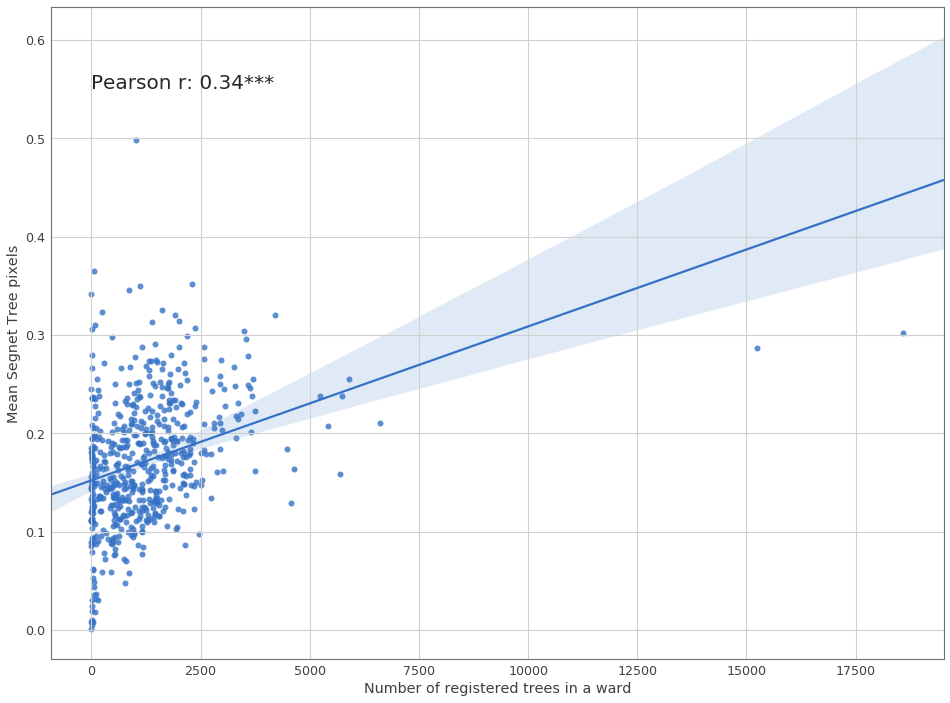

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeCount", y="Tree", data=filtered_df);
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Mean Segnet Tree pixels')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(0.1, 0.55),fontsize = 20)

(0.4101144047260674, 4.672856898754393e-25)


Text(3000,0.55,'Pearson r: 0.41***')

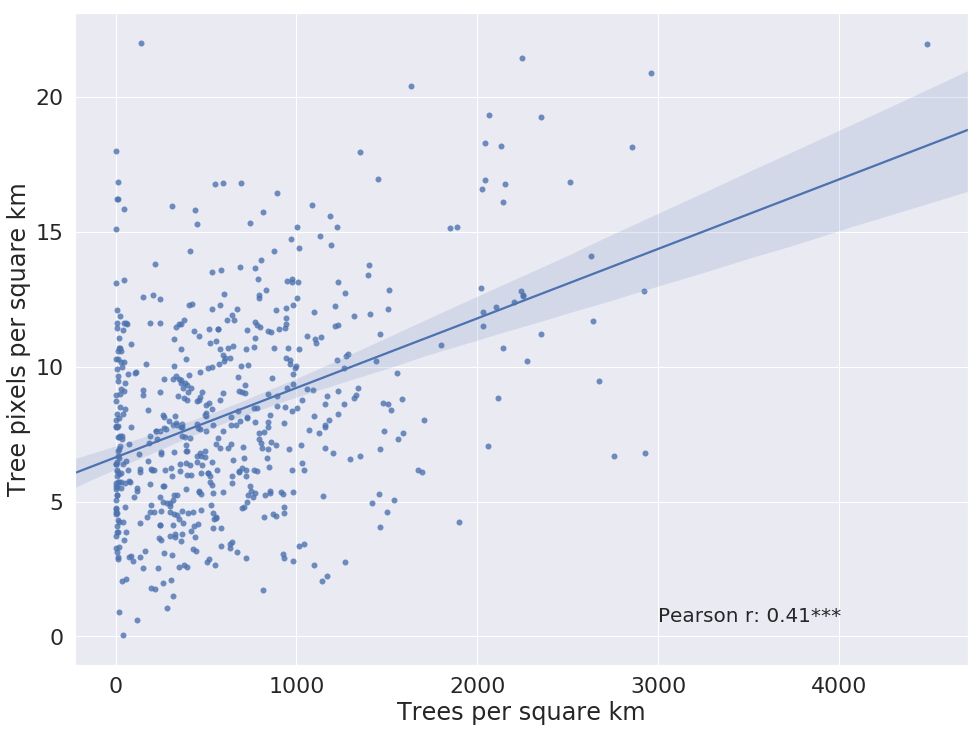

In [55]:
corr = pearsonr(filtered_df['TreeDensity'],filtered_df['TreePixelDensity'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeDensity", y="TreePixelDensity", data=filtered_df);
plt.xlabel('Trees per square km')
plt.ylabel('Tree pixels per square km')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(3000, 0.55),fontsize = 20)

(0.7389237235450882, 1.054084913732035e-101)


Text(10,25,'Pearson r: 0.73***')

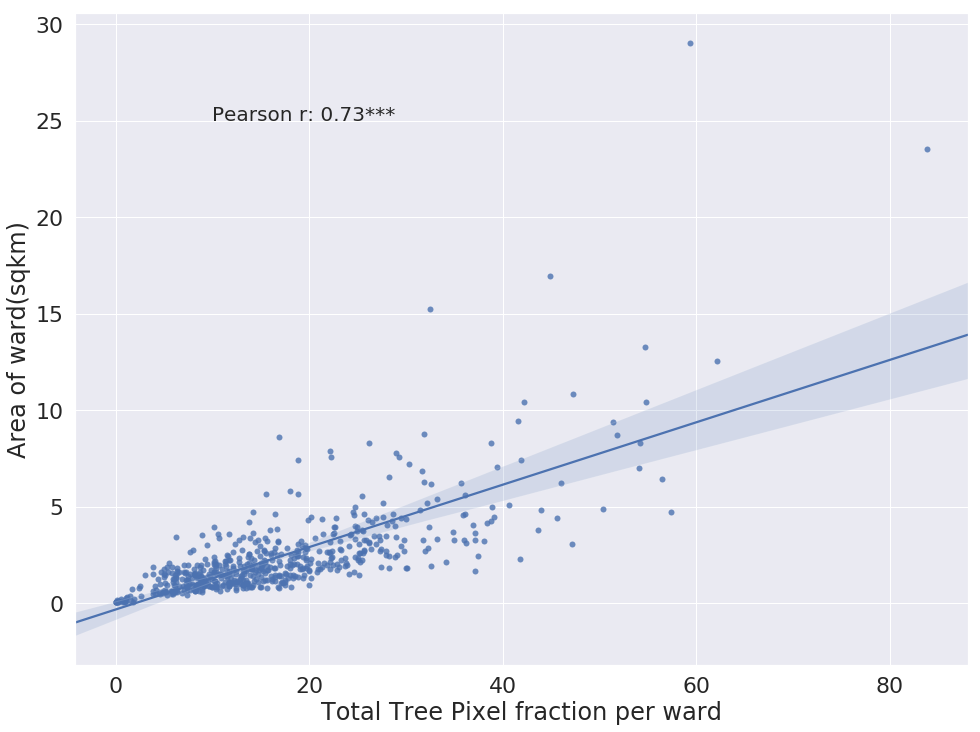

In [56]:
corr = pearsonr(filtered_df['TreeTotal'],filtered_df['area_km']/10.0)
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x=filtered_df['TreeTotal'], y=filtered_df['area_km']/10.0)
plt.xlabel('Total Tree Pixel fraction per ward')
plt.ylabel('Area of ward(sqkm)')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(10, 25),fontsize = 20)

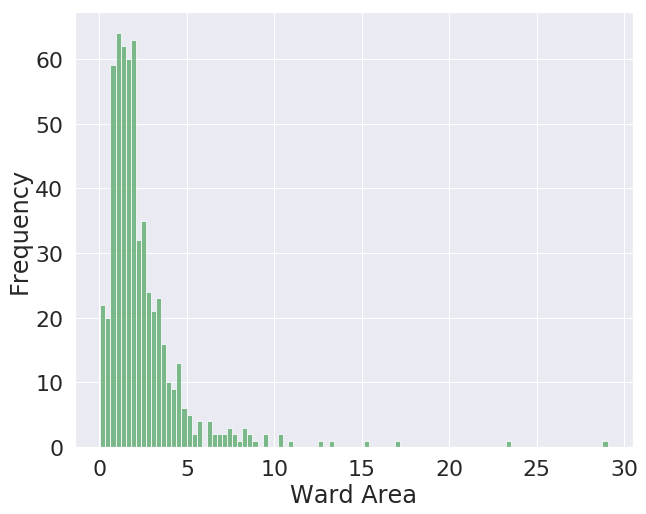

In [57]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Ward Area')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(filtered_df['area_km']/10.0, 100, facecolor='g', alpha=0.75)

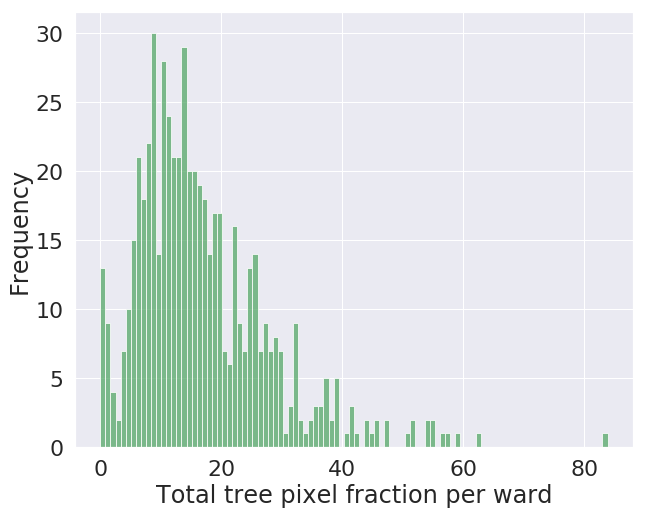

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Total tree pixel fraction per ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(filtered_df['TreeTotal'], 100, facecolor='g', alpha=0.75)

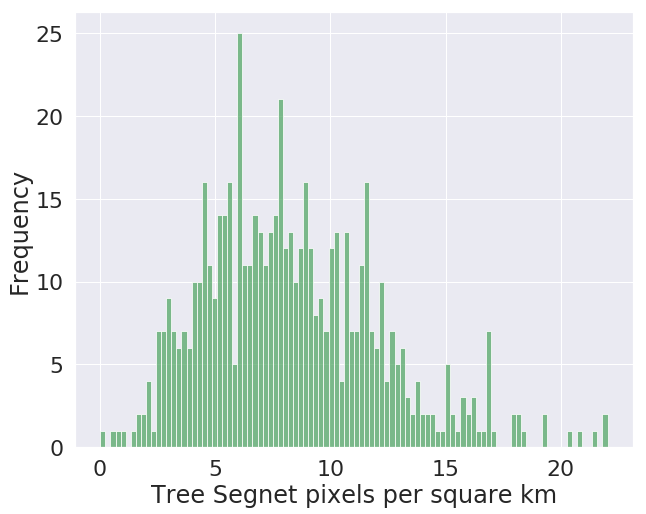

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Tree Segnet pixels per square km')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(filtered_df['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

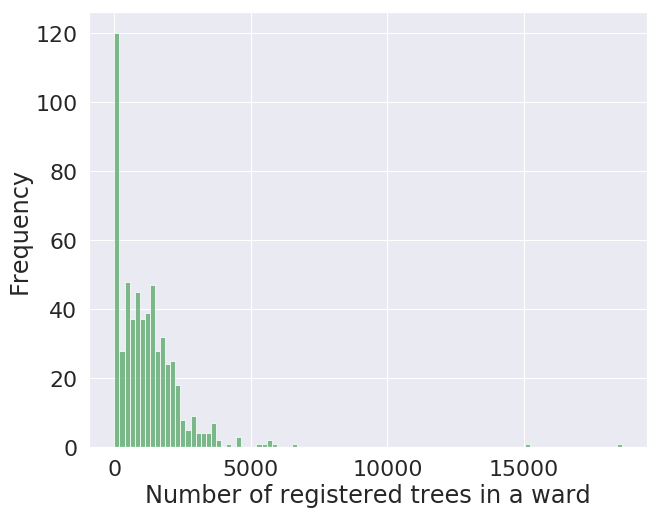

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(filtered_df['TreeCount'], 100, facecolor='g', alpha=0.75)

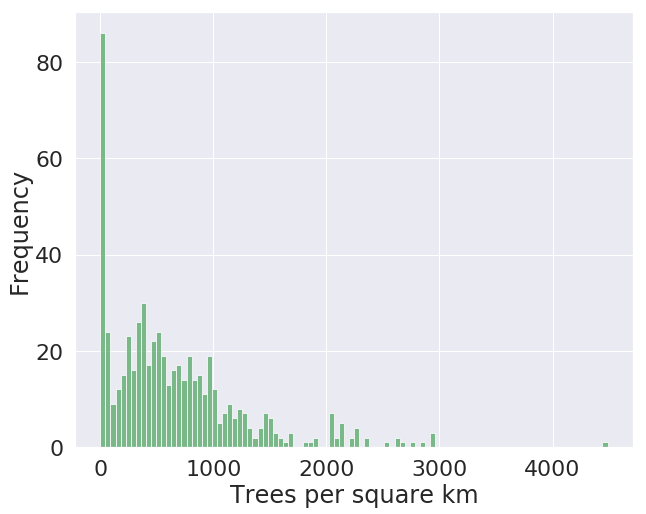

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Trees per square km')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(filtered_df['TreeDensity'], 100, facecolor='g', alpha=0.75)

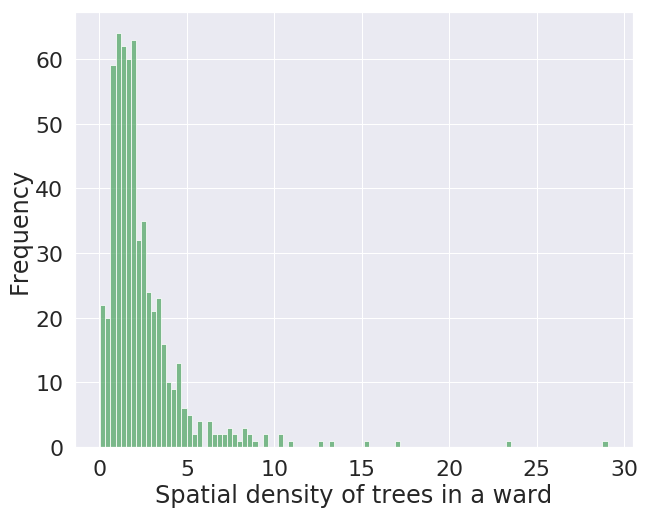

In [62]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Spatial density of trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(filtered_df['area_km']/10, 100, facecolor='g', alpha=0.75)

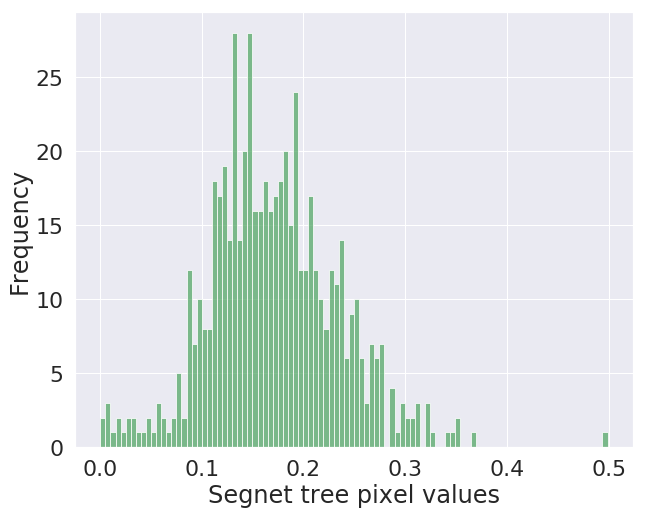

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(filtered_df['Tree'], 100, facecolor='g', alpha=0.75)

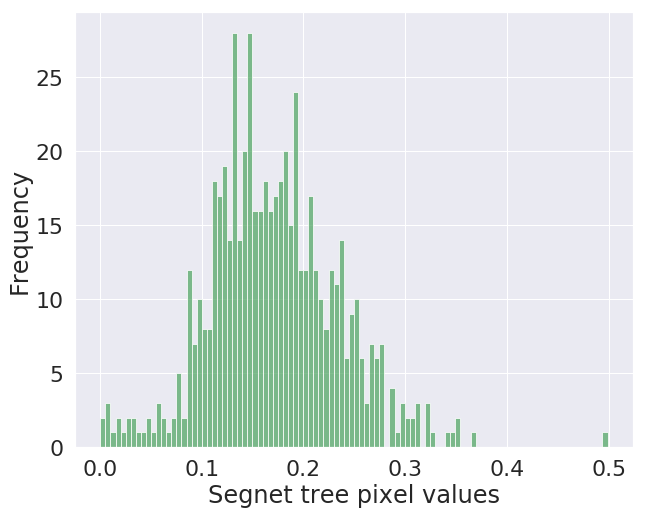

In [64]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(filtered_df['Tree'], 100, facecolor='g', alpha=0.75)

(0.035559551295034665, 0.39142959003598865)


Text(3000,5e-05,'Pearson r: 0.035***')

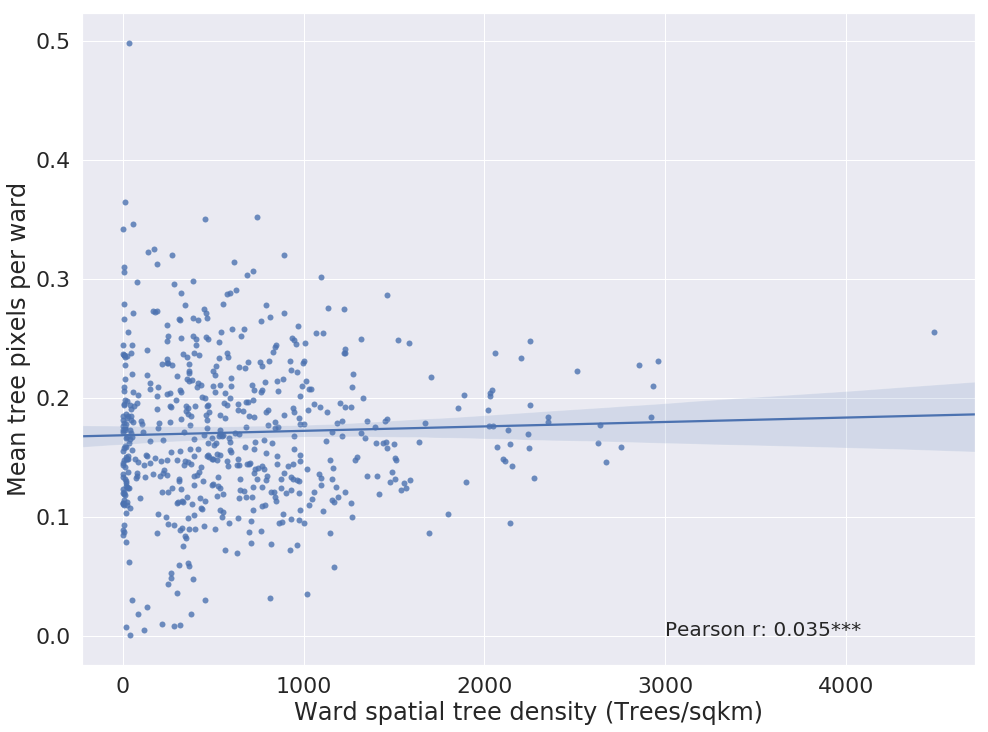

In [65]:
corr = pearsonr(filtered_df['TreeDensity'],filtered_df['Tree'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeDensity", y="Tree", data=filtered_df);
plt.xlabel('Ward spatial tree density (Trees/sqkm)')
plt.ylabel('Mean tree pixels per ward')
ax.annotate("Pearson r: " +  str(corr[0])[:5] + '***',  xy=(3000, 0.00005),fontsize = 20)

(0.05680919864336115, 0.17073593424564773)


Text(2,-3,'Pearson r: 0.05***')

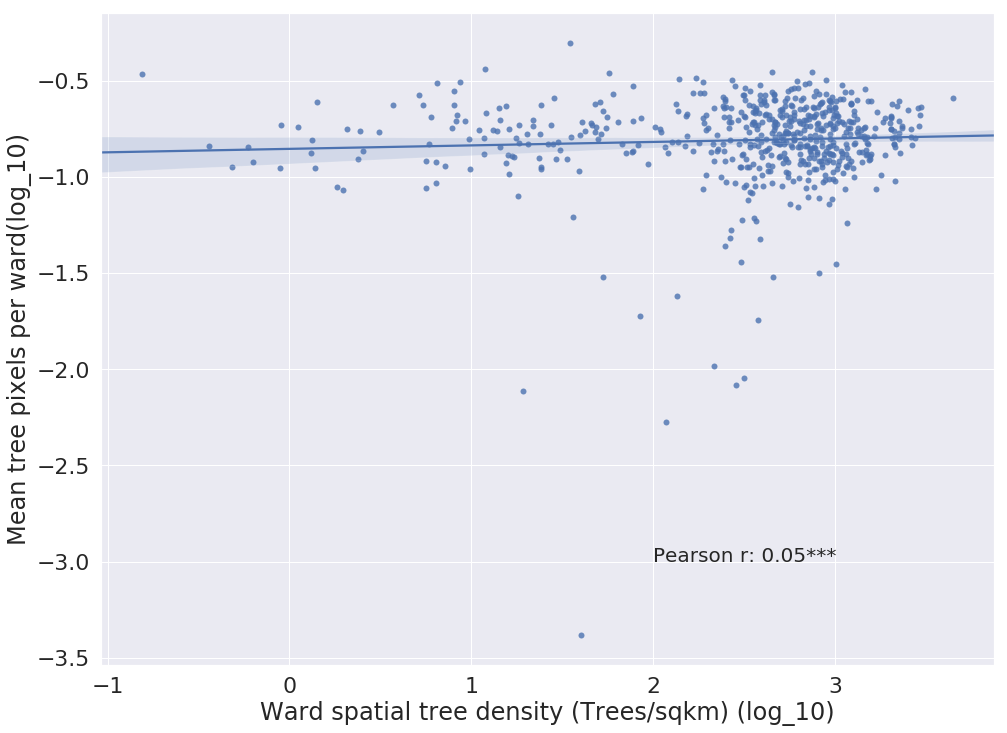

In [66]:
corr = pearsonr(np.log10(filtered_df['TreeDensity']),np.log10(filtered_df['Tree']))
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x=np.log10(filtered_df['TreeDensity']), y=np.log10(filtered_df['Tree']));
plt.xlabel('Ward spatial tree density (Trees/sqkm) (log_10)')
plt.ylabel('Mean tree pixels per ward(log_10)')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(2, -3 ),fontsize = 20)

In [67]:
min(filtered_df['TreeCount'])

1

In [69]:
ward_csv_CRESH = pd.read_csv('../Data/Geo_Data//uk_ward_greenspace.csv')

In [70]:
ward_csv_CRESH.head()

,casward2001,greenspace_pc
0,00AAFA,8.383184
1,00AAFE,24.354640
2,00AAFQ,10.795210
3,00AAFS,22.745890
4,00AAFT,22.767050
